# Imports

In [1]:
#import datatable as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

import missingno as msno

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split,cross_validate

from imblearn.under_sampling import RandomUnderSampler  
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from mlxtend.plotting import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from pprint import pprint

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import time

from dtreeviz.trees import dtreeviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

sns.set()

In [2]:
#import os
#os.chdir('..')

In [3]:
df_covid_na = pd.read_csv("COVID.csv",index_col=0)

# Tratando a base (resumo)

## pregnancy

Sabemos que homens não podem engravidar. Vamos ver quantos desses valores faltantes são de pacientes do gênero masculino (sex=0):

Vamos preencher esses valores com 0.

In [4]:
male_mask = df_covid_na['sex'] == 0
df_covid_na['pregnancy'].iloc[:][male_mask] = 0

## contact_other_covid

Como essa é uma feature é uma declaração (e não uma medição objetiva) e existe um conflito de interesse nessa declaração, dada as proporções contraditórias encontradas nos dados, optamos por remover a feature.

In [5]:
df_covid_na.drop(columns = 'contact_other_covid', inplace=True)

## icu e intubed

Sabemos que apenas os pacientes que foram internados (pacient_type=0) podem ter ido para a UTI ou terem sido intubados.

Vamos considerar que,  se 'patient_type' == 1, então 'intubed' = 0 e 'icu' = 0.

In [6]:
mask = df_covid_na['patient_type'] == 1
df_covid_na.loc[mask,'icu'] = 0
df_covid_na.loc[mask,'intubed'] = 0

## Reavaliando os valores faltantes:

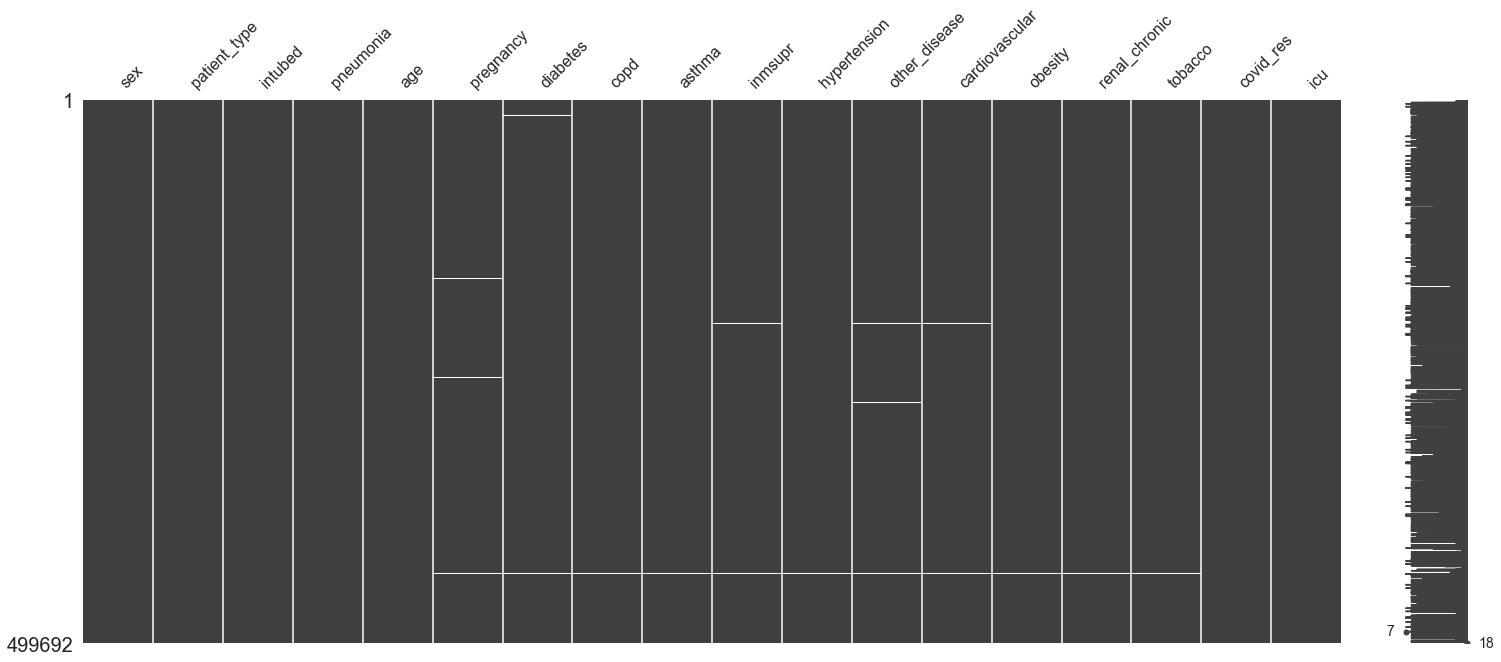

In [7]:
msno.matrix(df_covid_na);

Dada a baixa representatividade dos valores faltantes, não vamos acrescentar muito viés se preenchermos os valores faltantes com a moda, exceto pela idade, que será a mediana.

In [8]:
df_covid_na.mode()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu
0,0,1,0.0,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [9]:
df_covid_na['age'].median()

41.0

Colunas binárias para preencher os valores faltantes

In [10]:
boolean_na_columns = df_covid_na.columns.drop(['covid_res','age'])
boolean_na_columns

Index(['sex', 'patient_type', 'intubed', 'pneumonia', 'pregnancy', 'diabetes',
       'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'icu'],
      dtype='object')

In [11]:
int_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
boolean_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df_covid = pd.DataFrame(columns = df_covid_na.columns)
df_covid[boolean_na_columns] = pd.DataFrame(boolean_imputer.fit_transform(df_covid_na[boolean_na_columns]))
df_covid['age'] = pd.DataFrame(int_imputer.fit_transform(df_covid_na[['age']]))
df_covid['covid_res'] = df_covid_na['covid_res']

In [12]:
df_covid.head()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu
0,0.0,1.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,0.0,1.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,1.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0
3,0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
4,1.0,0.0,0.0,0.0,60.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0


In [13]:
df_covid.isna().sum()

sex               0
patient_type      0
intubed           0
pneumonia         0
age               0
pregnancy         0
diabetes          0
copd              0
asthma            0
inmsupr           0
hypertension      0
other_disease     0
cardiovascular    0
obesity           0
renal_chronic     0
tobacco           0
covid_res         0
icu               0
dtype: int64

# Fazendo alguns ajustes no dataframe

## Ajustando o tipo dos dados

In [14]:
df_covid = df_covid.astype('uint8')
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499692 entries, 0 to 499691
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   sex             499692 non-null  uint8
 1   patient_type    499692 non-null  uint8
 2   intubed         499692 non-null  uint8
 3   pneumonia       499692 non-null  uint8
 4   age             499692 non-null  uint8
 5   pregnancy       499692 non-null  uint8
 6   diabetes        499692 non-null  uint8
 7   copd            499692 non-null  uint8
 8   asthma          499692 non-null  uint8
 9   inmsupr         499692 non-null  uint8
 10  hypertension    499692 non-null  uint8
 11  other_disease   499692 non-null  uint8
 12  cardiovascular  499692 non-null  uint8
 13  obesity         499692 non-null  uint8
 14  renal_chronic   499692 non-null  uint8
 15  tobacco         499692 non-null  uint8
 16  covid_res       499692 non-null  uint8
 17  icu             499692 non-null  uint8
dtypes: u

## Alterando a ordem das colunas.

In [15]:
ordered_columns = ['sex', 'age', 'pregnancy', 'pneumonia',
       'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco',
       'other_disease', 'patient_type', 'icu', 'intubed', 'covid_res']

In [16]:
df_covid = df_covid[ordered_columns]

## Renomeando a feature patient_type

Para evitar confusão, vamos renomear patient_type para home_treatment, indicando que, quando 1, o paciente foi tratado fora do ambiente hospitalar (em casa).

In [17]:
df_covid.rename(columns={'patient_type':'home_treatment'},inplace=True)

# EDA (resumo)

Surpreendentemente podemos observar que existem pacientes que foram intubados e não foram para a UTI

In [18]:
#pacientes que foram intubados fora da UTI.
mask = (df_covid['icu']==0) & (df_covid['intubed']==1)

Todo paciente intubado deveria estar na UTI (alguns hospitais diferenciam leitos intensivos de semi intensivos). Não sei se é o caso desse hospital, se não haviam leitos disponíveis (mas é pouco provável que houvessem respiradores nesse caso), ou se foi um erro de digitação.
Como essa estatística não fará parte de nossa análise, vamos considerar que todos os pacientes que foram intubados, foram pra UTI (ou semi intensiva).

In [19]:
df_covid.loc[mask,'icu'] = 1

Removendo outliers de idade

In [20]:
iqt = df_covid['age'].quantile(0.75)-df_covid['age'].quantile(0.25)
age_limit = df_covid['age'].quantile(0.75)+1.5*iqt
age_limit

86.0

In [21]:
mask = df_covid['age']<=age_limit
df_covid = df_covid[mask]

Como sabemos, gravidez após os 50 anos é extremamente rara. Vamos considerar como erro de digitação ocorrência de gravidez em mulheres com mais de 55 anos

In [22]:
mask = df_covid['age']>55
df_covid.loc[mask,'pregnancy'] = 0

# Modelos

## Objetivo do modelo

Em caso de um cenário de escassez de testes, esse modelo poderá ser usado como uma triagem, para identificar quais pacientes tem mais chances de estar com covid, aumentando assim, as chances de identificarmos um caso positivo.

Tendo em vista esse objetivo, a nossa métrica alvo será o recall. O valor alvo do recall deverá ser definido de acordo com a relação entre a taxa de pacientes e a quantidade de testes disponíveis. Para fins de desenvolvimento, vamos adotar 60% como recall alvo.

Tendo isso em mente, vamos treinar alguns modelos e ver como eles desempenham.

## Dividindo os dados

In [23]:
target = 'covid_res'
features = df_covid.columns.drop([target])

X = df_covid[features]
y = df_covid[target]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y)

## Normalizando as bases

In [24]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std,columns = X.columns)
X_test_std = std.transform(X_test)
X_test_std = pd.DataFrame(X_test_std,columns = X.columns)

## Modelos candidatos

In [25]:
#funções auxiliares para treinar modelos para cada clusters e depois fazer o stack
from sklearn.base import clone as clone_model

def stack_fit(base_est = LogisticRegression(),
              final_est = LogisticRegression(),
              X_train=None,
              y_train=None,
              clusters=None):

    #lista com os modelos treinados com cada cluster
    stacked_models =  []
    
    #lista com as predições dos os modelos treinados com cada cluster
    X_train_stack = pd.DataFrame([])

    #para cada cluster, treine um modelo e coloque na lista
    for cluster in np.unique(clusters_us):
        #seleciona 1 cluster
        mask = clusters_us == cluster
        X_train_cl = X_train[mask]
        y_train_cl = y_train[mask]
        
        #treina 1 modelo para cada cluster
        estimator = clone_model(base_est)
        #base_estimator = LGBMClassifier(random_state = random_seed,verbose=-1)
        estimator.fit(X_train_cl,y_train_cl)

        stacked_models.append(estimator)
    
    #faça a predição de cada um dos modelos da lista
    for cluster,model in enumerate(stacked_models):
        #salva as predições desse modelo
        X_train_stack[cluster] = model.predict(X_train)
    
    stack_estimator = clone_model(final_est)
    stack_estimator.fit(X_train_stack,y_train)
        
    #retorna a lista com os modelos treinados
    return stacked_models, stack_estimator

def stack_predict(stacked_models,
                  stack_estimator,
                  X_test,
                  ts
                 ):

    X_test_stack = pd.DataFrame([])

    for cluster,model in enumerate(stacked_models):
        #salva as predições desse modelo
        X_test_stack[cluster] = model.predict(X_test)
    
    y_proba_stack = stack_estimator.predict_proba(X_test_stack)
    y_pred_stack = (y_proba_stack[:,1] > ts).astype(int)  

    return y_pred_stack, y_proba_stack

In [26]:
def run_model(model, X_train, y_train, X_test, proba=True):
    '''
    Escalona os dados e roda o modelo através de um pipeline.
    Pode retornar ou não as probabilidades de cada predição.
    Retorno: y_pred, y_proba
    dados preditos e probabilidade dos dados
    
    model            -> modelo
    X_train, y_train -> base de treino
    X_test           -> base de teste
    proba, binário: 
                     True  : Retorna as probabilidades. 
                     False : Retorna NONE
    '''
    
    ct = make_column_transformer((StandardScaler(),X_train.columns))  

    pipe = make_pipeline(ct, model)

    pipe.fit(X_train, y_train)
 
    y_pred = pipe.predict(X_test)
    
    if proba:
        try:
            y_proba = pipe.predict_proba(X_test)
        except:
            y_proba = None
    else:
        y_proba = None
    
    return y_pred, y_proba

In [27]:
def metrics_info(y_test, y_pred, show_cm = True):
    '''
    imprime o classification report e o ROC-AUC para os dados preditos e,
    caso show_cm = True, plota a matriz de confusão também
    '''
    print(classification_report(y_test, y_pred))
    auc = round(roc_auc_score(y_test, y_pred, multi_class="ovr", average="macro"),2)
    print('AUC:',auc)
    if show_cm:
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(conf_mat=cm)
        plt.show()

In [28]:
def test_models_plot_roc_auc_curve(
        model_list,
        X_train,
        X_test,
        y_train,
        y_test,
        stacked_clusters = False,
        clusters = None
):
    """
        model_list       : Lista de modelos a serem testados
                           Formato (List[Dict[model_name|estimator, name|Model]])
        X_train          : Dados de treino (features)
        X_test           : Dados de teste (features)
        y_train          : Dados de treino (alvo)
        y_test           : Dados de teste (alvo)
        stacked_clusters : Usa as funções auxiliares para fit e predict para modelos separados por clusters
    """

    response = {}
    
    for mdl in model_list:

        model = mdl.get('estimator')

        s_fit = time.time()
        
        
        if stacked_clusters:
            #Chama as funções do Stacked CBU
            stacked_models, stack_estimator = stack_fit(model,LogisticRegression(),X_train,y_train,clusters_us)
            y_predict, y_predict_proba = stack_predict(stacked_models, stack_estimator,X_test,ts = 0.5)

        else:
            #fit predict tradicional
            model.fit(X_train,y_train)
            y_predict_proba = model.predict_proba(X_test)
            y_predict  = model.predict(X_test)
        
        e_predict = time.time()

        fit_predict_time = round(e_predict-s_fit,3)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:,1])

        model_name = mdl.get('model_name')
        accuracy = accuracy_score(y_test, y_predict)
        auc = roc_auc_score(y_test, y_predict)
        
        #precision e recall separado por classes
        cm = confusion_matrix(y_test, y_predict)
        precision = cm.diagonal()/cm.sum(axis=0)
        recall = cm.diagonal()/cm.sum(axis=1)
        
        f1 = f1_score(y_test, y_predict, average='weighted')
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl.get('model_name'), auc))

        print(f"Model        : {model_name}")
        print(f"Time         : {fit_predict_time} ")
        print("======================")

        response[mdl.get('model_name')]  = {
            "accuracy": accuracy,
            "precision[0]": precision[0],
            "recall[0]": recall[0],
            "precision[1]": precision[1],
            "recall[1]": recall[1],
            "f1_score": f1,
            "auc": auc,
            "time":fit_predict_time
        }
        

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()
    return response


In [29]:
#configurações para tirar alguns warnings
XGBoost_warning = {'use_label_encoder':False,'eval_metric' :'logloss'}
#configurações para usar o modelo da GPU
XGBoost_gpu = {'tree_method':'gpu_hist', 'gpu_id':0,'predictor':'gpu_predictor'}


random_seed = 42

list_models = [
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed,n_jobs=-1)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)},
{'model_name': 'GradientBoosting',
 'estimator' : GradientBoostingClassifier(random_state = random_seed)},
{'model_name': 'XGBoost',
 'estimator' : XGBClassifier(random_state = random_seed,**XGBoost_warning,**XGBoost_gpu)},
{'model_name': 'LightGBM',
 'estimator' : LGBMClassifier(random_state = random_seed,verbose=-1)},
{'model_name': 'LogisticRegression',
 'estimator' : LogisticRegression(n_jobs=-1)}
]

Model        : Random Forest
Time         : 4.451 
Model        : AdaBoost
Time         : 6.27 
Model        : GradientBoosting
Time         : 14.01 
Model        : XGBoost
Time         : 0.99 
Model        : LightGBM
Time         : 0.444 
Model        : LogisticRegression
Time         : 1.581 


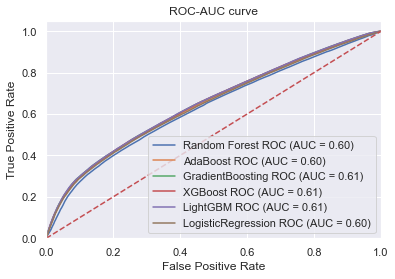

In [30]:
response_bank = test_models_plot_roc_auc_curve(list_models,
                                               X_train_std,
                                               X_test_std,
                                               y_train,
                                               y_test)

In [31]:
candidates = (pd.DataFrame(response_bank).T).sort_values('recall[1]',ascending=False)
candidates

,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
LogisticRegression,0.631000,0.625644,0.844824,0.647433,0.360494,0.605977,0.602659,1.581
AdaBoost,0.634084,0.626399,0.854472,0.658672,0.355274,0.607516,0.604873,6.270
XGBoost,0.635260,0.626177,0.860896,0.665306,0.349811,0.607365,0.605353,0.990
Random Forest,0.624987,0.620456,0.846171,0.639468,0.345169,0.597800,0.595670,4.451
LightGBM,0.636389,0.625892,0.867477,0.672357,0.344042,0.607073,0.605760,0.444
GradientBoosting,0.636059,0.625654,0.867320,0.671746,0.343495,0.606679,0.605407,14.010


## Balanceando os dados

### SMOTE

In [32]:
#%%time
#smote = SMOTE(random_state=42,sampling_strategy='auto',n_jobs=-1)
#X_train_sm, y_train_sm = smote.fit_resample(X_train_std, y_train)
#X_train_sm = pd.DataFrame(X_train_sm,columns = X.columns)

Para carragar usando o pickle

In [33]:
import pickle

X_train_sm_file_name = 'X_train_sm'
y_train_sm_file_name = 'y_train_sm'
X_test_std_file_name = 'X_test_std'
y_test_file_name = 'y_test'

file = open(X_train_sm_file_name,'rb')
X_train_sm = pickle.load(file)
file.close()

file = open(y_train_sm_file_name,'rb')
y_train_sm = pickle.load(file)
file.close()

In [34]:
y_train.value_counts()

0    193958
1    153314
Name: covid_res, dtype: int64

In [35]:
y_train_sm.value_counts()

1    193958
0    193958
Name: covid_res, dtype: int64

Model        : Random Forest
Time         : 5.488 
Model        : AdaBoost
Time         : 8.241 
Model        : GradientBoosting
Time         : 21.999 
Model        : XGBoost
Time         : 0.869 
Model        : LightGBM
Time         : 0.493 
Model        : LogisticRegression
Time         : 1.476 


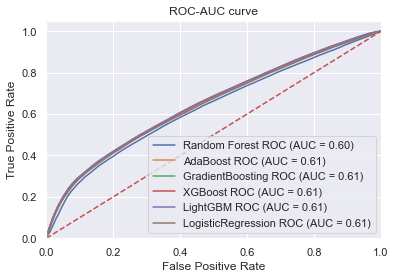

In [36]:
response_bank_sm = test_models_plot_roc_auc_curve(list_models,
                                                  X_train_sm,
                                                  X_test_std,
                                                  y_train_sm,
                                                  y_test)

In [37]:
candidates_sm = (pd.DataFrame(response_bank_sm).T).sort_values('recall[1]',ascending=False)
candidates_sm

,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
LogisticRegression,0.619685,0.641315,0.723982,0.582776,0.487741,0.614318,0.605861,1.476
AdaBoost,0.624032,0.640285,0.745889,0.593765,0.469874,0.616458,0.607881,8.241
GradientBoosting,0.627338,0.640097,0.760192,0.602203,0.459266,0.618228,0.609729,21.999
LightGBM,0.630133,0.637820,0.781582,0.613464,0.438538,0.618113,0.610060,0.493
XGBoost,0.630321,0.636803,0.786923,0.615883,0.432207,0.617418,0.609565,0.869
Random Forest,0.619779,0.629416,0.776289,0.598445,0.421782,0.606723,0.599035,5.488


### CBU (Clustering Based Undersampling)

Tentei seguir esse artigo, mas, pelo o que eu entendi, ele treinou um modelo por cluster e depois fez um stack para ponderar a predição dos modelos. Após o balanceamento de cada cluster, eu juntei os dados de todos os clusters do dataframe e treinei apenas um modelo.

https://arxiv.org/ftp/arxiv/papers/2005/2005.03582.pdf

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.base import clone
from sklearn.utils import check_random_state
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier

##### Calculando o número de clusters

In [39]:
def calculate_wcss(data):
    wcss = []

    for n in range(2, 20):
        model = KMeans(n_clusters=n, random_state=42)
        model.fit(X=data)
        wcss.append(model.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


In [40]:
#n_clusters = optimal_number_of_clusters(calculate_wcss(X_train_std))
#n_clusters

In [41]:
n_clusters=12
n_clusters

12

#### Criando os clusters

In [42]:
km = KMeans(n_clusters= n_clusters,random_state=42)
km.fit(X_train_std)
km_clusters = km.predict(X_train_std)
km_clusters

array([0, 4, 0, ..., 0, 0, 1])

#### Checando a estabilidade dos clusters

In [43]:
def get_dict(cluster_centers):
    '''Recebe os centróides de n instancias do Kmeans. Adota o primeiro conjunto de centróides como referência e, através da comparação das distâncias euclidianas entre os centróides, identifica a equivalência dos clusters para as diferentes instâncias de kmeans.
    Retorna um dicionário de dicionários com essa equivalência (sendo que o -1 sempre equivale a si mesmo).
    Exemplo:
    {1: {-1: -1, 6: 0, 5: 1, 2: 2, 4: 3, 3: 4, 1: 5, 0: 6},
     2: {-1: -1, 4: 0, 0: 1, 6: 2, 3: 3, 1: 4, 2: 5, 5: 6},
     3: {-1: -1, 4: 0, 0: 1, 2: 2, 3: 3, 1: 4, 5: 5, 6: 6}}
    Aqui, podemos entender que, para a instância 1, o label 6 equivale ao label 0 da primeira instancia, o lebel 5 equivale ao label 1 e assim sucessivamente.
    '''
    dicts = {}
    for n_center,other_centers in enumerate(cluster_centers[1:]):
        d=[]
        #nesse primeiro for, pega o cluster zero como referência
        #e guarda os centróides de cada cluster em uma lista
        for i,center_a in enumerate(cluster_centers[0]):
            d.append([])
            
            #nesse segundo for, calcula a distância euclidiana de cada centróide das outras instâncias do kmeans
            #em relação aos centróides de referência
            for j,center_b in enumerate(other_centers):
                d[i].append(distance.euclidean(center_a, center_b))
        
        #array com as distâncias euclidianas
        np_d=np.array(d)

        dict_center = {-1:-1}
        
        #esse for verifica qual label tem o centróide mais próximo do centróide do label de referência
        #e monta o dicionário
        for i,center in enumerate(np_d):
            k=0
            #esse while é pra resolver algum possível empate. 
            #caso um dos elementos da equivalência identificada já tenha sido atribuído,
            #defina a equivalência como o segundo centróide mais próximo
            while True:
                #defina a chave do dicionário como a posição da menor distância euclidiana
                dict_key = np.argpartition(center, k)[k]
                #caso a posição no dicionário esteja vazia, atribua a equivalência
                if dict_center.get(dict_key)==None:
                    dict_center[dict_key] = i
                    break
                #caso a posição não esteja vazia, faça a equivalência com o segundo mais próximo (ou treceiro, ou quarto...)
                else:
                    k+=1
                    dict_key = np.argpartition(center, k)[k]
        #guarde as equivalências dessa instancia do kmeans no dicionário a ser retornado
        dicts[n_center+1] = dict_center
    return dicts

def get_score(labels,cluster_centers,n_iter):
    '''Recebe um vetor com os labels, os centróides de cada label e o número de iterações.
    Retorna o score médio de semelhança entre os clusters equivalentes
    '''
    dict_map = get_dict(cluster_centers)
    mapped_labels=labels.copy()

    #converte os labels para labes equivalentes
    for i in range(1,len(labels)):
        mapped_labels[i] = np.vectorize(dict_map[i].get)(labels[i])

    score=np.array([])
    
    #calcula o percentual de labels que são iguais 
    for label_a in mapped_labels:
        for label_b in mapped_labels:
            #defina uma m´scara excluindo as posições com -1
            mask = (label_a==-1)|(label_b==-1)
            
            #calcule um vetor binário onde as posições iguais são True e as diferentes são False
            same = label_a[~mask]==label_b[~mask]
            
            #conte quantos valores são True e quantos são False
            #salve no score o valor percentual da contagem de True: sum(True)/(sum(True)+sum(False))
            count = np.unique(same, return_counts=True)
            score=np.append(score,count[1][-1]/count[1].sum())

    #mascare com uma matriz triangular (para ignorar a diagonal)
    mask_score = (1-np.triu(np.ones(n_iter, dtype='int')))
    mask_score = np.where(mask_score.ravel()==1)
    #retorne a média dos scores
    return score.ravel()[mask_score].mean()

def kmeans_stability(X,est,n_iter):    
    rng = np.random.RandomState(42)
    labels = []
    indices = []
    cluster_centers = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)

        est = clone(est)
        if hasattr(est, "random_state"):
            # randomize estimator if possible
            est.random_state = rng.randint(1e5)

        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        cluster_centers.append(est.cluster_centers_)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype='int')
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    
    score = get_score(labels,cluster_centers,n_iter)
    return score

In [44]:
#kmeans_stability(X_train_std, km, n_iter=20)

#### Perfil dos clusters

##### Distribuição de resultados positivos e negativos em cada cluster

In [45]:
for cluster in np.unique(km_clusters):    
    print('Cluster:',cluster)
    mask = km_clusters== cluster
    print(y_train[mask].value_counts())

Cluster: 0
0    64626
1    48263
Name: covid_res, dtype: int64
Cluster: 1
1    28695
0    11622
Name: covid_res, dtype: int64
Cluster: 2
1    4490
0    1751
Name: covid_res, dtype: int64
Cluster: 3
0    2780
1    2620
Name: covid_res, dtype: int64
Cluster: 4
0    77419
1    45638
Name: covid_res, dtype: int64
Cluster: 5
0    1551
1    1017
Name: covid_res, dtype: int64
Cluster: 6
0    14554
1     9111
Name: covid_res, dtype: int64
Cluster: 7
0    6116
1    3538
Name: covid_res, dtype: int64
Cluster: 8
0    2720
1    2374
Name: covid_res, dtype: int64
Cluster: 9
0    3088
1    1801
Name: covid_res, dtype: int64
Cluster: 10
0    4638
1    3202
Name: covid_res, dtype: int64
Cluster: 11
0    3093
1    2565
Name: covid_res, dtype: int64


##### Visualização dos clusters

In [46]:
pca = PCA(4)
components = pca.fit_transform(X_train_std)

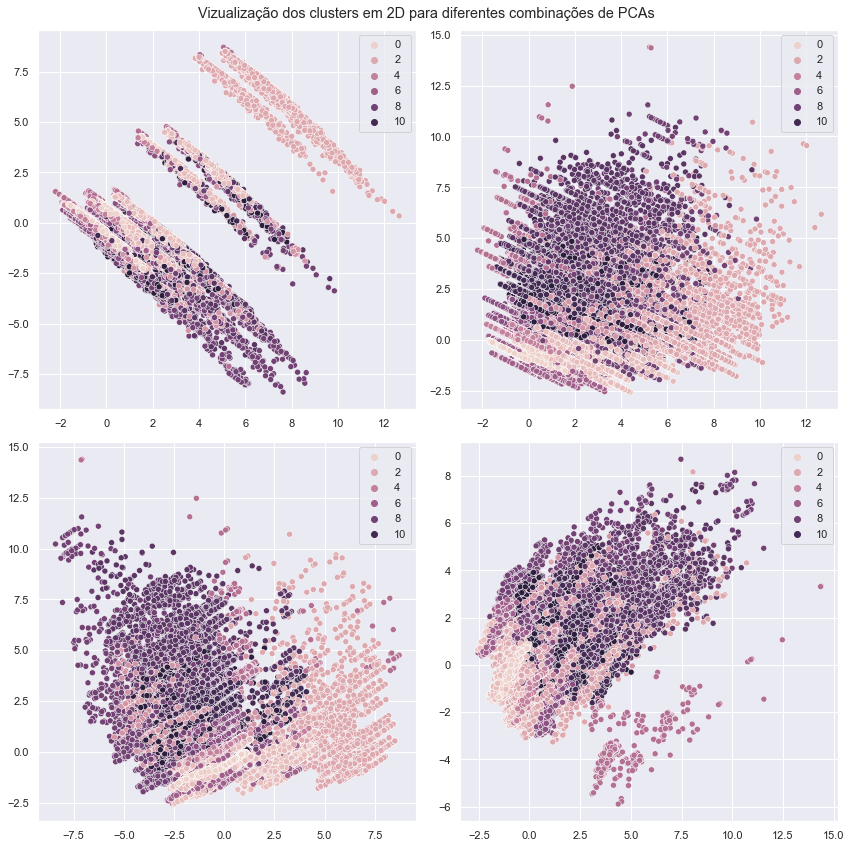

In [47]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.scatterplot(x=components[:,0],y=components[:,1],hue=km_clusters,ax=ax[0][0])
sns.scatterplot(x=components[:,0],y=components[:,2],hue=km_clusters,ax=ax[0][1])
sns.scatterplot(x=components[:,1],y=components[:,2],hue=km_clusters,ax=ax[1][0])
sns.scatterplot(x=components[:,2],y=components[:,3],hue=km_clusters,ax=ax[1][1])

fig.suptitle('Vizualização dos clusters em 2D para diferentes combinações de PCAs')

fig.tight_layout()

#### Visualização em 3d utilizando as 3 principais componentes do PCA

In [48]:
#import plotly
#import plotly.graph_objs as go
#
## Configure Plotly to be rendered inline in the notebook.
#plotly.offline.init_notebook_mode()
#
## Configure the trace.
#trace = go.Scatter3d(
#    x=components[:,0],  # <-- Put your data instead
#    y=components[:,1],  # <-- Put your data instead
#    z=components[:,2],  # <-- Put your data instead
#    mode='markers',
#    marker={
#        'size': 5,
#        'opacity': 0.8,
#        'color':km_clusters,
#        'colorscale':'deep'
#    }
#)
#
## Configure the layout.
#layout = go.Layout(
#    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
#)
#
#data = [trace]
#
#plot_figure = go.Figure(data=data, layout=layout)
#
## Render the plot.
#plotly.offline.iplot(plot_figure)

#### Fazendo o undersampling em cada cluster

In [49]:
rus = RandomUnderSampler(random_state=1)

X_train_us=np.array([])
clusters_us = []

#para cada cluster
for cluster in np.unique(km_clusters):

    #faça o undersamping dentro da cada cluster
    mask = km_clusters == cluster
    X_train_temp, y_train_temp = rus.fit_resample(X_train_std[mask],y_train[mask])
    cluster_temp = np.ones_like(y_train_temp)*cluster

    #concatene os clusters para formar a base de treino
    if (cluster == 0):
        X_train_us  = X_train_temp
        y_train_us  = y_train_temp
        clusters_us = cluster_temp
    else:  
        X_train_us  = np.concatenate([X_train_us , X_train_temp])
        y_train_us  = np.concatenate([y_train_us , y_train_temp])
        clusters_us = np.concatenate([clusters_us, cluster_temp])

In [50]:
X_train_us = pd.DataFrame(X_train_us,columns = X.columns)
y_train_us = pd.Series(y_train_us)
X_train_us.head()

,sex,age,pregnancy,pneumonia,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,other_disease,home_treatment,icu,intubed
0,-0.985426,0.976099,-0.086313,-0.42962,2.657272,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
1,-0.985426,-0.012050,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
2,-0.985426,-0.444366,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
3,-0.985426,-0.876681,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
4,-0.985426,-0.259088,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522


In [51]:
print('Originalmente')
y_train.value_counts()

Originalmente


0    193958
1    153314
Name: covid_res, dtype: int64

In [52]:
print('Após SMOTE')
y_train_sm.value_counts()

Após SMOTE


1    193958
0    193958
Name: covid_res, dtype: int64

In [53]:
print('Após CBU')
y_train_us.value_counts()

Após CBU


0    133502
1    133502
dtype: int64

#### Calculando o desempenho dos modelo

Model        : Random Forest
Time         : 2.553 
Model        : AdaBoost
Time         : 4.929 
Model        : GradientBoosting
Time         : 10.178 
Model        : XGBoost
Time         : 0.998 
Model        : LightGBM
Time         : 0.388 
Model        : LogisticRegression
Time         : 1.046 


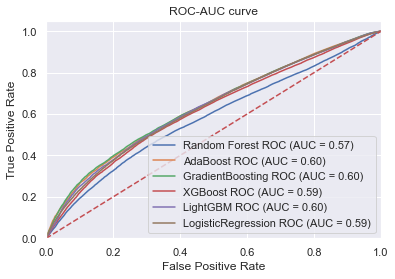

In [54]:
response_bank_us = test_models_plot_roc_auc_curve(list_models,
                                                  X_train_us,
                                                  X_test_std,
                                                  y_train_us,
                                                  y_test)

In [55]:
candidates_cbu = (pd.DataFrame(response_bank_us).T).sort_values('recall[1]',ascending=False)
candidates_cbu

,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
AdaBoost,0.597566,0.647533,0.613281,0.541453,0.577686,0.598615,0.595483,4.929
LogisticRegression,0.594771,0.641603,0.621774,0.539516,0.560610,0.595476,0.591192,1.046
GradientBoosting,0.602276,0.644691,0.641371,0.549240,0.552818,0.602409,0.597095,10.178
LightGBM,0.604474,0.639529,0.668788,0.555247,0.523110,0.603003,0.595949,0.388
XGBoost,0.601443,0.633659,0.678893,0.553444,0.503462,0.598887,0.591178,0.998
Random Forest,0.584854,0.613170,0.695411,0.535925,0.444991,0.578657,0.570201,2.553


### Treinando um modelo com cada cluster e depois fazendo o stack

Aqui, implementei a estrutura mais parecida com o artigo mencionado anteriormente (https://arxiv.org/ftp/arxiv/papers/2005/2005.03582.pdf).

Agora existe um modelo para cada cluster. Esses modelos são usados para predizer os resultados e depois, usamos um outro estimador para ponderar esses resultados e obter a predição final.

Diferenças:
- Por praticidade eu balanceei todos os clusters (os altamente desbalanceados e os pouco desbalanceados)
- O cross validation não foi implementado nesse momento

Model        : Random Forest
Time         : 6.942 
Model        : AdaBoost
Time         : 24.193 
Model        : GradientBoosting
Time         : 11.052 
Model        : XGBoost
Time         : 5.762 
Model        : LightGBM
Time         : 2.855 
Model        : LogisticRegression
Time         : 5.525 


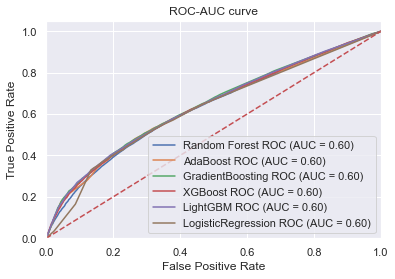

In [56]:
response_bank_stack = test_models_plot_roc_auc_curve(list_models,
                                                     X_train_us,
                                                     X_test_std,
                                                     y_train_us,
                                                     y_test,
                                                     stacked_clusters=True,
                                                     clusters = clusters_us
                                                    )

In [57]:
candidates_stack = (pd.DataFrame(response_bank_stack).T).sort_values('recall[1]',ascending=False)
candidates_stack

,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
GradientBoosting,0.603573,0.650700,0.626550,0.548741,0.574505,0.604372,0.600528,11.052
LogisticRegression,0.598655,0.646994,0.619308,0.543125,0.572527,0.599556,0.595917,5.525
LightGBM,0.604158,0.648758,0.635116,0.550352,0.564993,0.604653,0.600054,2.855
XGBoost,0.603627,0.647557,0.637017,0.550060,0.561386,0.604020,0.599201,5.762
Random Forest,0.606140,0.647180,0.648168,0.554041,0.552970,0.606100,0.600569,6.942
AdaBoost,0.611112,0.647221,0.667597,0.562038,0.539653,0.610174,0.603625,24.193


## Comparando o resultado das estratégias de balanceamento

In [58]:
print('Tabelas ordenadas pelo nome do modelo para facilitar a comparação')

print('\n\nSem balanceamento')
display(candidates.sort_index())

print('\n\nSMOTE')
display(candidates_sm.sort_index())

print('\n\nCBU')
display(candidates_cbu.sort_index())

print('\n\nStacked CBU')
display(candidates_stack.sort_index())

Tabelas ordenadas pelo nome do modelo para facilitar a comparação


Sem balanceamento


,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
AdaBoost,0.634084,0.626399,0.854472,0.658672,0.355274,0.607516,0.604873,6.270
GradientBoosting,0.636059,0.625654,0.867320,0.671746,0.343495,0.606679,0.605407,14.010
LightGBM,0.636389,0.625892,0.867477,0.672357,0.344042,0.607073,0.605760,0.444
LogisticRegression,0.631000,0.625644,0.844824,0.647433,0.360494,0.605977,0.602659,1.581
Random Forest,0.624987,0.620456,0.846171,0.639468,0.345169,0.597800,0.595670,4.451
XGBoost,0.635260,0.626177,0.860896,0.665306,0.349811,0.607365,0.605353,0.990




SMOTE


,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
AdaBoost,0.624032,0.640285,0.745889,0.593765,0.469874,0.616458,0.607881,8.241
GradientBoosting,0.627338,0.640097,0.760192,0.602203,0.459266,0.618228,0.609729,21.999
LightGBM,0.630133,0.637820,0.781582,0.613464,0.438538,0.618113,0.610060,0.493
LogisticRegression,0.619685,0.641315,0.723982,0.582776,0.487741,0.614318,0.605861,1.476
Random Forest,0.619779,0.629416,0.776289,0.598445,0.421782,0.606723,0.599035,5.488
XGBoost,0.630321,0.636803,0.786923,0.615883,0.432207,0.617418,0.609565,0.869




CBU


,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
AdaBoost,0.597566,0.647533,0.613281,0.541453,0.577686,0.598615,0.595483,4.929
GradientBoosting,0.602276,0.644691,0.641371,0.549240,0.552818,0.602409,0.597095,10.178
LightGBM,0.604474,0.639529,0.668788,0.555247,0.523110,0.603003,0.595949,0.388
LogisticRegression,0.594771,0.641603,0.621774,0.539516,0.560610,0.595476,0.591192,1.046
Random Forest,0.584854,0.613170,0.695411,0.535925,0.444991,0.578657,0.570201,2.553
XGBoost,0.601443,0.633659,0.678893,0.553444,0.503462,0.598887,0.591178,0.998




Stacked CBU


,accuracy,precision[0],recall[0],precision[1],recall[1],f1_score,auc,time
AdaBoost,0.611112,0.647221,0.667597,0.562038,0.539653,0.610174,0.603625,24.193
GradientBoosting,0.603573,0.650700,0.626550,0.548741,0.574505,0.604372,0.600528,11.052
LightGBM,0.604158,0.648758,0.635116,0.550352,0.564993,0.604653,0.600054,2.855
LogisticRegression,0.598655,0.646994,0.619308,0.543125,0.572527,0.599556,0.595917,5.525
Random Forest,0.606140,0.647180,0.648168,0.554041,0.552970,0.606100,0.600569,6.942
XGBoost,0.603627,0.647557,0.637017,0.550060,0.561386,0.604020,0.599201,5.762


Usando o método de Stacked CBU, exceto pelo ADA Boost, todos os modelos tiveram um desempenho melhor para a classe 1 (precision e recall).

O que mais chamou a atenção foi a melhora do Random Forest.

Embora tenha diminuido o recall da classe 1 no ADA Bosst, o método Stacked CBU, melhorou o precision da classe 1, o recall da classe 0, a acurácia, o f1 score e o ROC-AUC.

## Ajustando o ts

### Light GBM

In [59]:
model = LGBMClassifier(random_state = 42,verbose=-1)
stacked_models, stack_estimator = stack_fit(model,LogisticRegression(),X_train_us,y_train_us,clusters_us)

ts = 0.478
y_pred_ts, _ = stack_predict(stacked_models, stack_estimator,X_test_std,ts = ts)

print(classification_report(y_test,y_pred_ts))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62     83125
           1       0.54      0.60      0.57     65707

    accuracy                           0.59    148832
   macro avg       0.59      0.59      0.59    148832
weighted avg       0.60      0.59      0.60    148832



### XG Boost

In [60]:
model = XGBClassifier(random_state = 42,**XGBoost_warning,**XGBoost_gpu)
stacked_models, stack_estimator = stack_fit(model,LogisticRegression(),X_train_us,y_train_us,clusters_us)

ts = 0.487
y_pred_ts, _ = stack_predict(stacked_models, stack_estimator,X_test_std,ts = ts)

print(classification_report(y_test,y_pred_ts))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62     83125
           1       0.54      0.60      0.57     65707

    accuracy                           0.60    148832
   macro avg       0.60      0.60      0.59    148832
weighted avg       0.60      0.60      0.60    148832



### Gradient Boosting

In [61]:
model = GradientBoostingClassifier(random_state = 42)
stacked_models, stack_estimator = stack_fit(model,LogisticRegression(),X_train_us,y_train_us,clusters_us)

ts = 0.491
y_pred_ts, _ = stack_predict(stacked_models, stack_estimator,X_test_std,ts = ts)

print(classification_report(y_test,y_pred_ts))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62     83125
           1       0.54      0.61      0.57     65707

    accuracy                           0.60    148832
   macro avg       0.60      0.60      0.59    148832
weighted avg       0.60      0.60      0.60    148832



Ajustando o TS, conseguimos ganhar 1 ponto percentual em algumas métricas, mas não fugimos dos resultados encontrados no trabalho completo